In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Imagenet

In [2]:
from fastai.conv_learner import *
from torchvision import transforms, datasets
PATH = Path.home()/"data/imagenet-sz/160"

In [3]:
list(PATH.iterdir())

[PosixPath('/home/ubuntu/data/imagenet-sz/160/models'),
 PosixPath('/home/ubuntu/data/imagenet-sz/160/val'),
 PosixPath('/home/ubuntu/data/imagenet-sz/160/tmp'),
 PosixPath('/home/ubuntu/data/imagenet-sz/160/train'),
 PosixPath('/home/ubuntu/data/imagenet-sz/160/val2')]

In [4]:
bs=64
size=128

In [5]:
def get_data(size):
    traindir = PATH/'val'
    # traindir = PATH/'train'
    valdir = PATH/'val'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), normalize,
    ])

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs,
        num_workers=8, pin_memory=True)

    val_tfms = transforms.Compose([
        transforms.Resize(int(size*1.14)),
        transforms.CenterCrop(size),
        transforms.ToTensor(), normalize,
    ])
    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, val_tfms),
        batch_size=bs, shuffle=False,
        num_workers=8, pin_memory=True)
    
    md = ModelData(PATH, train_loader, val_loader)
    md.sz = size
    return md

In [6]:
data = [get_data(128), get_data(288)]

In [7]:
from models.resnet import resnet34
m = resnet34()

In [8]:
m = nn.DataParallel(m, [0,1,2,3])

In [9]:
learn = ConvLearner.from_model_data(m, data[0])
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd = 1e-4
lr = 1.3

In [10]:
def_phase = {'epochs':1, 'opt_fn':optim.SGD, 'wds':1e-4}

phases = [
    TrainingPhase(**def_phase, lr = (1e-3,1e-1), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, lr = 1e-1)]

In [11]:
# todo pass sampler, loss scale
learn.fit_opt_sched(phases, data_list=data)

epoch      trn_loss   val_loss   accuracy                   
    0      7.198716   6.937332   0.001057  
    1      7.219436   7.024954   0.001182                   



[7.024953890698897, 0.001181641029893445]

In [67]:
x,y = next(iter(learn.data.trn_dl))

In [68]:
x.shape

torch.Size([64, 3, 288, 288])

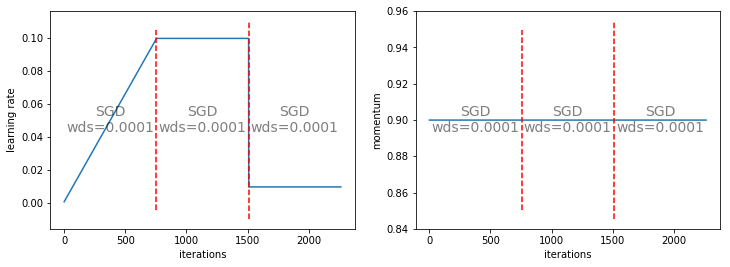

In [16]:
learn.sched.plot_lr()

In [63]:
class UpdateDataCB(Callback):
    def __init__(self, learn, epoch_lu):
        self.learn,self.phase,self.epoch_lu = learn,0,epoch_lu
        
    def on_phase_begin(self):
        if self.phase in self.epoch_lu:
            sz = epoch_lu[self.phase]
            print(f'\nUpdating size to {sz}\n')
            self.learn.set_data(get_data(sz))
        self.phase += 1

In [64]:
cb = UpdateDataCB(learn)